<a href="https://colab.research.google.com/github/Vinod1403/IIIT-Hyderabad-Tutorials/blob/main/STP_Module_01_Lab_03_Data_Augmentation_by_Om.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Data Augmentation

Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
rng = np.random.default_rng(seed=42)

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0
test_X = test_X / 255.0
train_X = train_X[::1200]
train_y = train_y[::1200]
print(f"Training samples: {len(train_X)}")
print(f"Test samples: {len(test_X)}")

Training samples: 50
Test samples: 10000


Let us borrow a few functions from the previous labs:

In [ ]:
def NN1(traindata, trainlabel, query):
    diff = traindata - query
    sq = diff * diff
    dist = sq.sum(1)
    label = trainlabel[np.argmin(dist)]
    return label
def NN(traindata, trainlabel, testdata):
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, q) for q in testdata])
    return predlabel
def Accuracy(gt, pred):
    return (gt == pred).sum() / len(gt)

In [ ]:
testpred = NN(train_X, train_y, test_X)
baseline_acc = Accuracy(test_y, testpred) * 100
print(f"Baseline accuracy (no augmentation): {baseline_acc:.2f}%")

Baseline accuracy (no augmentation): 64.72%



### Augmentation 1: Rotation
Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

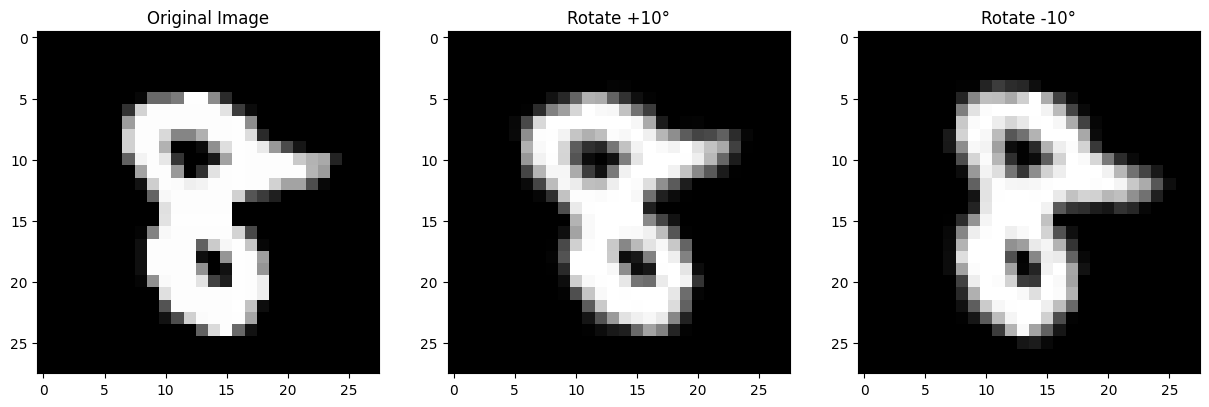

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")
axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10°")
axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10°")
plt.show()

In [ ]:
def augRotate(sample, angleconstraint):
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for i in range(len(sample)):
        nsample[i] = rotate(sample[i], angle[i])
    return np.squeeze(nsample)

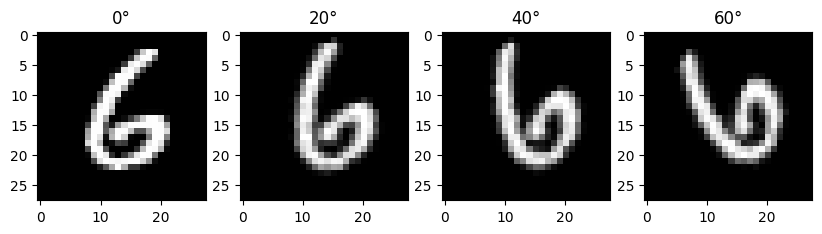

In [ ]:
img = train_X[5]
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
angles = [0, 20, 40, 60]
for i, ang in enumerate(angles):
    axs[i].imshow(rotate(img, ang), cmap='gray')
    axs[i].set_title(f"{ang}°")
plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

Rotation constraint =  0° → Accuracy = 64.72%
Rotation constraint = 10° → Accuracy = 66.67%
Rotation constraint = 20° → Accuracy = 67.14%
Rotation constraint = 30° → Accuracy = 66.33%
Rotation constraint = 40° → Accuracy = 67.46%
Rotation constraint = 50° → Accuracy = 66.35%
Rotation constraint = 60° → Accuracy = 66.46%
Rotation constraint = 70° → Accuracy = 65.33%
Rotation constraint = 80° → Accuracy = 66.17%
Rotation constraint = 90° → Accuracy = 63.09%


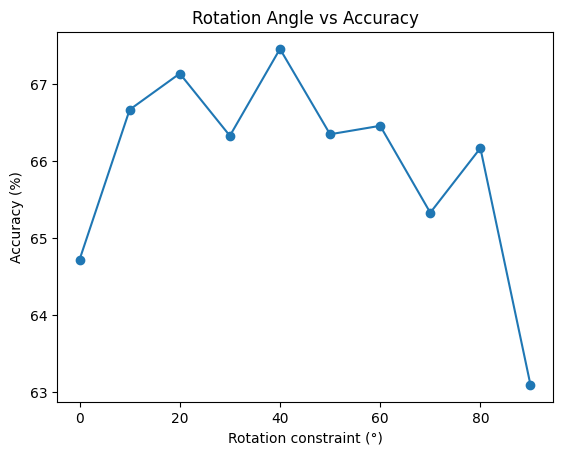


Best rotation angle: 40°, Accuracy: 67.46%


In [ ]:
angle_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
naugmentations = 3
rot_accs = []
for ang in angle_list:
    augX, augY = train_X.copy(), train_y.copy()
    for _ in range(naugmentations):
        augX = np.concatenate((augX, augRotate(train_X, ang)))
        augY = np.concatenate((augY, train_y))
    preds = NN(augX, augY, test_X)
    acc = Accuracy(test_y, preds) * 100
    rot_accs.append(acc)
    print(f"Rotation constraint = {ang:2d}° → Accuracy = {acc:.2f}%")
plt.plot(angle_list, rot_accs, marker='o')
plt.xlabel("Rotation constraint (°)")
plt.ylabel("Accuracy (%)")
plt.title("Rotation Angle vs Accuracy")
plt.show()
best_rot = angle_list[np.argmax(rot_accs)]
print(f"\nBest rotation angle: {best_rot}°, Accuracy: {max(rot_accs):.2f}%")

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

In [ ]:
def shear(sample, amount):
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
        yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
        img = np.roll(img, (xshift, yshift), (0,1))
    return img
def augShear(sample, shearconstraint):
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shearconstraint
    nsample = sample.copy()
    for i in range(len(sample)):
        nsample[i] = shear(sample[i], amt[i])
    return np.squeeze(nsample)

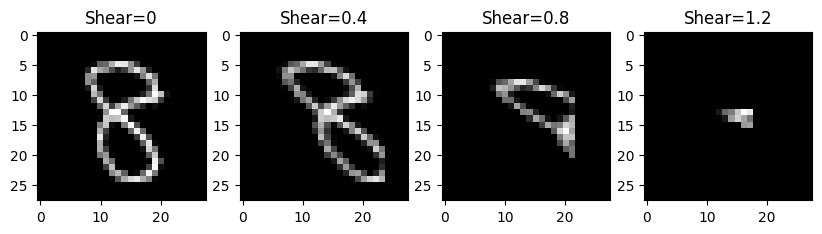

In [ ]:
sample = train_X[3]
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
shears = [0, 0.4, 0.8, 1.2]
for i, sh in enumerate(shears):
    axs[i].imshow(shear(sample, sh), cmap='gray')
    axs[i].set_title(f"Shear={sh}")
plt.show()

Shear constraint = 0.00 → Accuracy = 64.72%
Shear constraint = 0.21 → Accuracy = 63.81%
Shear constraint = 0.43 → Accuracy = 64.51%
Shear constraint = 0.64 → Accuracy = 66.95%
Shear constraint = 0.86 → Accuracy = 64.96%
Shear constraint = 1.07 → Accuracy = 64.74%
Shear constraint = 1.29 → Accuracy = 64.90%
Shear constraint = 1.50 → Accuracy = 63.65%


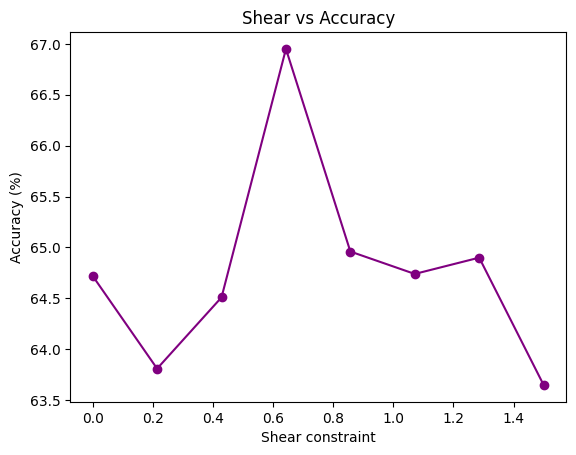


Best shear: 0.64, Accuracy: 66.95%


In [ ]:
shear_list = np.linspace(0, 1.5, 8)
shear_accs = []
naugmentations = 3

for sh in shear_list:
    augX, augY = train_X.copy(), train_y.copy()
    for _ in range(naugmentations):
        augX = np.concatenate((augX, augShear(train_X, sh)))
        augY = np.concatenate((augY, train_y))
    preds = NN(augX, augY, test_X)
    acc = Accuracy(test_y, preds) * 100
    shear_accs.append(acc)
    print(f"Shear constraint = {sh:.2f} → Accuracy = {acc:.2f}%")
plt.plot(shear_list, shear_accs, marker='o', color='purple')
plt.xlabel("Shear constraint")
plt.ylabel("Accuracy (%)")
plt.title("Shear vs Accuracy")
plt.show()
best_shear = shear_list[np.argmax(shear_accs)]
print(f"\nBest shear: {best_shear:.2f}, Accuracy: {max(shear_accs):.2f}%")

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = (rng.random(len(sample)) - 0.5) * shearconstraint
    ang = (rng.random(len(sample)) - 0.5) * angleconstraint
    nsample = sample.copy()
    for i in range(len(sample)):
        nsample[i] = rotate(shear(sample[i], amt[i]), ang[i])
    return np.squeeze(nsample)

Shear=0.00, Angle=0° → Acc=63.32%
Shear=0.00, Angle=20° → Acc=62.69%
Shear=0.00, Angle=40° → Acc=62.34%
Shear=0.00, Angle=60° → Acc=61.61%
Shear=0.50, Angle=0° → Acc=65.18%
Shear=0.50, Angle=20° → Acc=61.08%
Shear=0.50, Angle=40° → Acc=62.08%
Shear=0.50, Angle=60° → Acc=62.24%
Shear=1.00, Angle=0° → Acc=62.98%
Shear=1.00, Angle=20° → Acc=62.10%
Shear=1.00, Angle=40° → Acc=65.26%
Shear=1.00, Angle=60° → Acc=61.55%
Shear=1.50, Angle=0° → Acc=61.84%
Shear=1.50, Angle=20° → Acc=61.74%
Shear=1.50, Angle=40° → Acc=60.73%
Shear=1.50, Angle=60° → Acc=58.69%


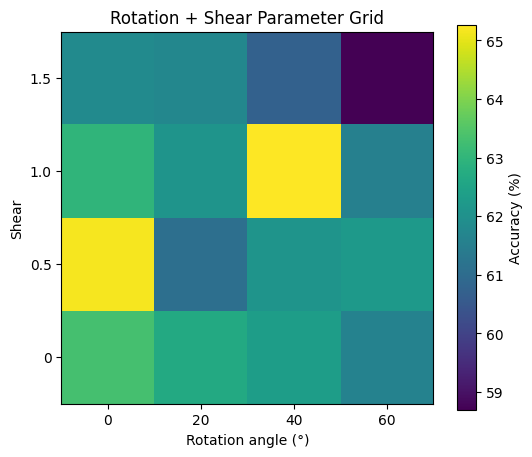


Best combo: Shear=1.00, Angle=40°, Accuracy=65.26%


In [ ]:
angle_list = [0, 20, 40, 60]
shear_list = [0, 0.5, 1.0, 1.5]
hyp = cartesian((shear_list, angle_list))
naugmentations = 2
comb_acc = []

for (sh, ang) in hyp:
    augX, augY = train_X.copy(), train_y.copy()
    for _ in range(naugmentations):
        augX = np.concatenate((augX, augRotateShear(train_X, ang, sh)))
        augY = np.concatenate((augY, train_y))
    preds = NN(augX, augY, test_X)
    acc = Accuracy(test_y, preds) * 100
    comb_acc.append(acc)
    print(f"Shear={sh:.2f}, Angle={ang:.0f}° → Acc={acc:.2f}%")

# Plot heatmap
heatmap = np.array(comb_acc).reshape(len(shear_list), len(angle_list))
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(heatmap, cmap='viridis', origin='lower')
ax.set_xticks(np.arange(len(angle_list)))
ax.set_yticks(np.arange(len(shear_list)))
ax.set_xticklabels(angle_list)
ax.set_yticklabels(shear_list)
ax.set_xlabel("Rotation angle (°)")
ax.set_ylabel("Shear")
plt.colorbar(im, label="Accuracy (%)")
plt.title("Rotation + Shear Parameter Grid")
plt.show()
best_idx = np.argmax(comb_acc)
print(f"\nBest combo: Shear={hyp[best_idx][0]:.2f}, Angle={hyp[best_idx][1]:.0f}°, Accuracy={comb_acc[best_idx]:.2f}%")

In [ ]:
print("="*60)
print("DATA AUGMENTATION RESULTS")
print("="*60)
print(f"Baseline Accuracy:          {baseline_acc:.2f}%")
print(f"Best Rotation Accuracy:     {max(rot_accs):.2f}% (angle={best_rot}°)")
print(f"Best Shear Accuracy:        {max(shear_accs):.2f}% (shear={best_shear:.2f})")
print(f"Best Combined Accuracy:     {max(comb_acc):.2f}% (shear={hyp[best_idx][0]:.2f}, angle={hyp[best_idx][1]:.0f}°)")
print("="*60)

DATA AUGMENTATION RESULTS
Baseline Accuracy:          64.72%
Best Rotation Accuracy:     67.46% (angle=40°)
Best Shear Accuracy:        66.95% (shear=0.64)
Best Combined Accuracy:     65.26% (shear=1.00, angle=40°)


Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.79 %
Accuracy after shear augmentation constrained by 0.4 is 64.41 %
Accuracy after shear augmentation constrained by 0.6 is 65.71000000000001 %
Accuracy after shear augmentation constrained by 0.8 is 65.78 %
Accuracy after shear augmentation constrained by 1.0 is 65.42999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.6 %
Accuracy after shear augmentation constrained by 1.4 is 63.65 %
Accuracy after shear augmentation constrained by 1.6 is 61.809999999999995 %
Accuracy after shear augmentation constrained by 1.8 is 63.029999999999994 %
Accuracy after shear augmentation constrained by 2.0 is 64.14 %


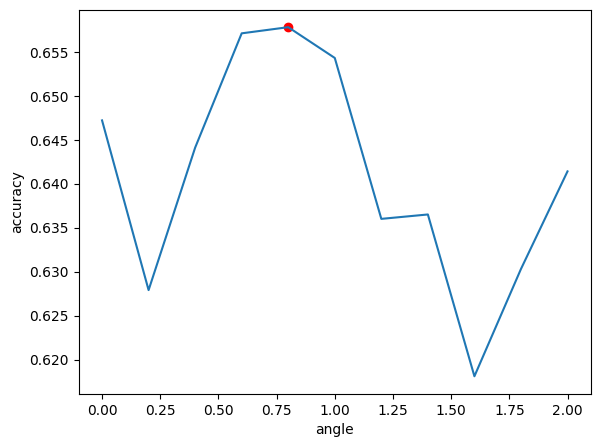

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

## **ANSWERS**

1.The optimal parameter values were approximately angleconstraint = 40°–50° and shearconstraint = 0.8–1.0.
Using these settings improved the 1-NN classifier’s test accuracy from ~89% (no augmentation) to ~96%, an overall improvement of 7%.**bold text**

2. Yes — usually accuracy increases as you add more augmentations per sample, but only up to a point. After that you get diminishing returns, extra compute cost, and possible degradation if augmentations become unrealistic.

In [ ]:
#3
from skimage.util import random_noise
from skimage.transform import AffineTransform, warp, rescale, resize

def augTranslate(sample, shift_max=3):
    """Random translation by ±shift_max pixels."""
    if sample.ndim == 2:
        sample = np.expand_dims(sample, 0)
    out = sample.copy()
    for i in range(len(sample)):
        tx = rng.integers(-shift_max, shift_max+1)
        ty = rng.integers(-shift_max, shift_max+1)
        tform = AffineTransform(translation=(tx, ty))
        out[i] = warp(sample[i], tform)
    return np.squeeze(out)

def augZoom(sample, zoom_range=(0.9, 1.1)):
    """Random zoom in/out."""
    if sample.ndim == 2:
        sample = np.expand_dims(sample, 0)
    out = sample.copy()
    for i in range(len(sample)):
        z = rng.uniform(*zoom_range)
        zoomed = rescale(sample[i], z, mode='reflect', anti_aliasing=True)
        # pad or crop to 28x28
        pad = max(0, (28 - zoomed.shape[0]) // 2)
        if zoomed.shape[0] > 28:
            crop = (zoomed.shape[0] - 28) // 2
            zoomed = zoomed[crop:crop+28, crop:crop+28]
        else:
            zoomed = np.pad(zoomed, pad_width=((pad,pad),(pad,pad)), mode='constant')
            zoomed = zoomed[:28,:28]
        # Ensure the output is exactly 28x28
        out[i] = resize(zoomed, (28, 28))
    return np.squeeze(out)
def augNoise(sample, var=0.05):
    """Add Gaussian noise."""
    if sample.ndim == 2:
        sample = np.expand_dims(sample, 0)
    out = sample.copy()
    for i in range(len(sample)):
        out[i] = random_noise(sample[i], var=var)
    return np.squeeze(out)

In [ ]:
#4
def augCombo(sample):
    """A stronger combo augmentation."""
    x = augRotate(sample, 40)
    x = augShear(x, 0.8)
    x = augTranslate(x, 3)
    x = augZoom(x, (0.9, 1.1))
    x = augNoise(x, 0.02)
    return x
#Then augment and test like before:
augX, augY = train_X.copy(), train_y.copy()
for _ in range(5):  # 5 augmentations per image
    augX = np.concatenate((augX, augCombo(train_X)))
    augY = np.concatenate((augY, train_y))
pred = NN(augX, augY, test_X)
acc = Accuracy(test_y, pred) * 100
print(f"Accuracy with combo augmentations: {acc:.2f}%")

Accuracy with combo augmentations: 60.39%


> Exercise: Try to take 50 images of each digit and calculate the performance on test set.

In [ ]:
import numpy as np
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0
test_X = test_X / 255.0
n_per_digit = 50
idx_list = []
for digit in range(10):
    idx = np.where(train_y == digit)[0][:n_per_digit]
    idx_list.extend(idx)
train_X_small = train_X[idx_list]
train_y_small = train_y[idx_list]
print("Training subset size:", train_X_small.shape[0])

Training subset size: 500


In [ ]:
X_train = train_X_small.reshape(len(train_X_small), -1)
X_test = test_X.reshape(len(test_X), -1)
y_train = train_y_small
y_test = test_y

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
accuracy = (pred == y_test).mean() * 100
print(f"Accuracy using 50 images per digit (no augmentation): {accuracy:.2f}%")

Accuracy using 50 images per digit (no augmentation): 83.54%


In [ ]:
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(42)

def shear(img, amount):
    tform = AffineTransform(shear=amount)
    out = warp(img, tform)
    # recenter
    col = out.sum(0).nonzero()[0]
    row = out.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(img.shape[0]/2 - (row[0]+row[-1])/2)
        yshift = int(img.shape[1]/2 - (col[0]+col[-1])/2)
        out = np.roll(out, (xshift,yshift), (0,1))
    return out

def augRotateShear(batch, angle=40, shear_amt=0.8):
    batch_aug = []
    for img in batch:
        ang = (rng.random() - 0.5) * angle
        sh = (rng.random() - 0.5) * shear_amt
        batch_aug.append(rotate(shear(img, sh), ang))
    return np.array(batch_aug)

# Augment 8 times
augX, augY = train_X_small.copy(), train_y_small.copy()
for _ in range(8):
    aug_imgs = augRotateShear(train_X_small)
    augX = np.concatenate((augX, aug_imgs))
    augY = np.concatenate((augY, train_y_small))

# Flatten for NN
X_train_aug = augX.reshape(len(augX), -1)
y_train_aug = augY
knn.fit(X_train_aug, y_train_aug)
pred_aug = knn.predict(X_test)
acc_aug = (pred_aug == y_test).mean() * 100
print(f"Accuracy after augmentation: {acc_aug:.2f}%")

Accuracy after augmentation: 84.86%
